In [23]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [1]:
import tensorflow as tf
import datetime
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import matplotlib.pyplot as plt
# local imports
from lib.plot_images import plot_images
from lib.confusion_matrix import create_confusion_matrix_callback

# Clear down the log files from all runs
Use this to clear out all the data that tensorboard shows

In [2]:
!rm -rf ./logs/ 

'rm' is not recognized as an internal or external command,
operable program or batch file.


# Training hyperparameters

In [3]:
batch_size = 32
epochs = 100

# This must match what is used in the javascript code

In [4]:
IMG_HEIGHT = 20
IMG_WIDTH = 20

# Data Generators
We defined two data generators, one that augments the data to make our training more general and one that just scales and centers the data.

In [5]:
augmented_image_gen = ImageDataGenerator(
    rotation_range=2,
    width_shift_range=.1,
    height_shift_range=.1,
    zoom_range=0.1,
    shear_range=2,
    brightness_range=[0.9, 1.1],
    validation_split=0.2,
    samplewise_center=True,
    samplewise_std_normalization=True)

normal_image_gen = ImageDataGenerator(
    validation_split=0.2,
    samplewise_center=True,
    samplewise_std_normalization=True
)

# Load in the data
For the training data and validation data it's important that they have the same seed so we get the correct validation subset for the training subset.

In [7]:
train_data_gen = augmented_image_gen.flow_from_directory(batch_size=batch_size,
                                                     directory="training_data",
                                                     color_mode="grayscale",
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical",
                                                     seed=65657867,
                                                     subset='training')
val_data_gen = normal_image_gen.flow_from_directory(batch_size=batch_size,
                                                     directory="training_data",
                                                     color_mode="grayscale",
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical",
                                                     seed=65657867,
                                                     subset='validation')
confusion_data_gen = normal_image_gen.flow_from_directory(batch_size=train_data_gen.samples,
                                                     directory="training_data",
                                                     color_mode="grayscale",
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical",
                                                     seed=65657867,
                                                     subset='validation')

Found 2232 images belonging to 9 classes.
Found 554 images belonging to 9 classes.
Found 554 images belonging to 9 classes.


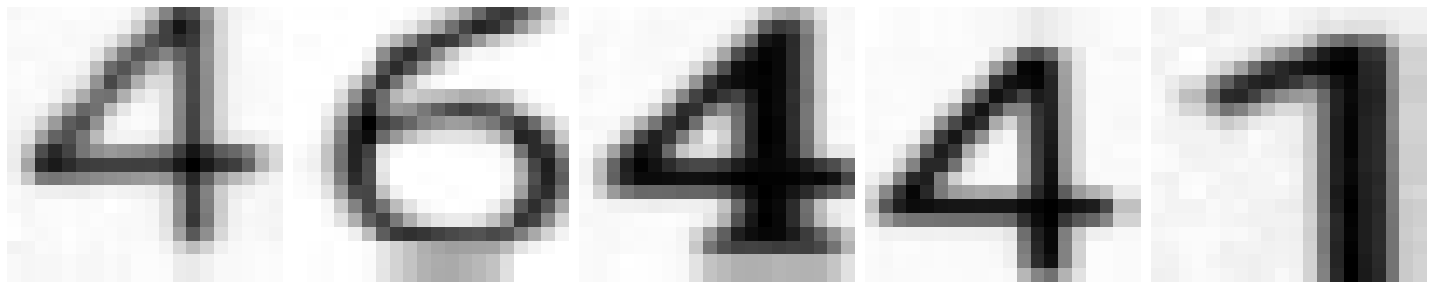

In [8]:
sample_training_images, _ = next(train_data_gen)
plot_images(sample_training_images[:5], IMG_WIDTH, IMG_HEIGHT)

# Our very simple model
A single convolution layer, followed by a dense layer followed by the output layer.
We're using linear regularisation and dropouts to prevent overfitting of the training data.

In [9]:
model = Sequential([
    Conv2D(16, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.0001),
           input_shape=(IMG_HEIGHT, IMG_WIDTH , 1)),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(
        50,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.0001)
    ),
    Dropout(0.2),
    Dense(9, activation='softmax')
])


# Logging to tensorboard
We log the training stats along with the confusion matrix of the test data - should we be using the validation data for this?

In [10]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_confusion_matrix = create_confusion_matrix_callback(model, confusion_data_gen, log_dir)
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Show tensorboard inline

In [11]:
# launch tensorboard inline with the workbook
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


# Do the actual training

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    callbacks=[tensorboard_callback, cm_callback]
)

C:\Users\admin\AppData\Local\Temp\ipykernel_1536\4098809375.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
69/69 [==============================] - 17s 217ms/step - loss: 0.9701 - accuracy: 0.6950 - val_loss: 0.0716 - val_accuracy: 0.9926
Epoch 2/100
69/69 [==============================] - 4s 52ms/step - loss: 0.2845 - accuracy: 0.9123 - val_loss: 0.0342 - val_accuracy: 0.9926
Epoch 3/100
69/69 [==============================] - 4s 55ms/step - loss: 0.1912 - accuracy: 0.9427 - val_loss: 0.0291 - val_accuracy: 0.9963
Epoch 4/100
69/69 [==============================] - 4s 51ms/step - loss: 0.1689 - accuracy: 0.9536 - val_loss: 0.0278 - val_accuracy: 0.9945
Epoch 5/100
69/69 [==============================] - 4s 56ms/step - loss: 0.1329 - accuracy: 0.9650 - val_loss: 0.0328 - val_accuracy: 0.9926
Epoch 6/100
69/69 [==============================] - 5s 74ms/step - loss: 0.1350 - accuracy: 0.9714 - val_loss: 0.0263 - val_accuracy: 0.9963
Epoch 7/100
69/69 [==============================] - 4s 64ms/step - loss: 0.1150 - accuracy: 0.9700 - val_loss: 0.0183 - val_accuracy: 0.9982
Epoc

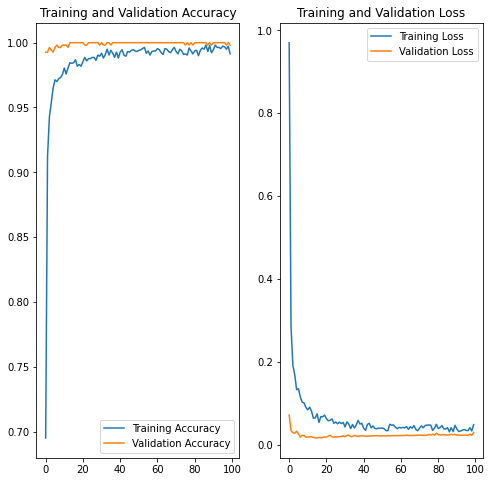

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
model.save("trained.model")

INFO:tensorflow:Assets written to: trained.model\assets


# Train on all the available data for our final model

In [16]:
all_data_gen = augmented_image_gen.flow_from_directory(batch_size=batch_size,
                                                     directory="all_data",
                                                     color_mode="grayscale",
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical")

Found 3096 images belonging to 9 classes.


In [17]:
all_history = model.fit_generator(
    all_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=50)

C:\Users\admin\AppData\Local\Temp\ipykernel_1536\1084889071.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  all_history = model.fit_generator(


Epoch 1/50
69/69 [==============================] - 13s 197ms/step - loss: 0.0338 - accuracy: 0.9964
Epoch 2/50
69/69 [==============================] - 5s 73ms/step - loss: 0.0423 - accuracy: 0.9941
Epoch 3/50
69/69 [==============================] - 3s 45ms/step - loss: 0.0329 - accuracy: 0.9973
Epoch 4/50
69/69 [==============================] - 3s 42ms/step - loss: 0.0386 - accuracy: 0.9936
Epoch 5/50
69/69 [==============================] - 3s 38ms/step - loss: 0.0327 - accuracy: 0.9977
Epoch 6/50
69/69 [==============================] - 3s 44ms/step - loss: 0.0312 - accuracy: 0.9977
Epoch 7/50
69/69 [==============================] - 3s 37ms/step - loss: 0.0356 - accuracy: 0.9950
Epoch 8/50
69/69 [==============================] - 2s 34ms/step - loss: 0.0390 - accuracy: 0.9923
Epoch 9/50
69/69 [==============================] - 2s 32ms/step - loss: 0.0454 - accuracy: 0.9927
Epoch 10/50
69/69 [==============================] - 2s 32ms/step - loss: 0.0492 - accuracy: 0.9918
Epoch 1

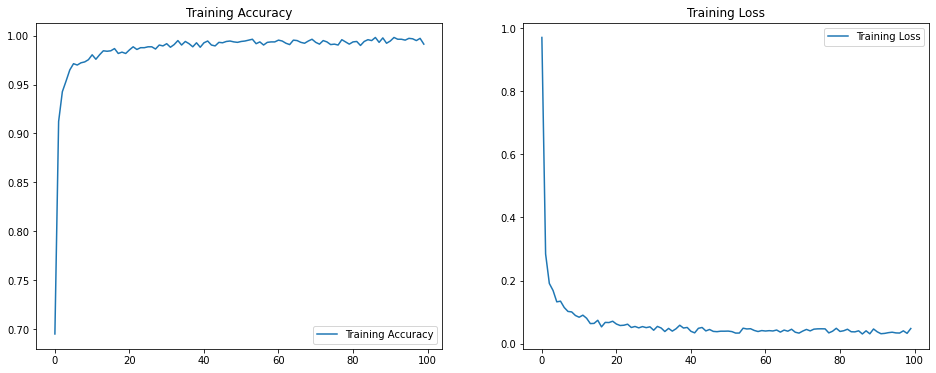

In [18]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [19]:
model.save("trained.model")

INFO:tensorflow:Assets written to: trained.model\assets


In [20]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, "tfjs_model")